In [162]:
from pytorch_lightning import LightningModule
import wandb
from pytorch_lightning.loggers import WandbLogger
from abc import abstractmethod  
from collections import OrderedDict

class MLP(nn.Module):
    def __init__(self, in_size, n_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_size, in_size // 2),
            nn.ReLU(),
            nn.Linear(in_size // 2, in_size // 4),
            nn.ReLU(),
            nn.Linear(in_size // 4, n_classes)
        )
        
    def forward(self, x):
        return F.log_softmax(self.model(x), dim=1)
    
    
class DeepCNN(nn.Module):
    def __init__(self, in_channels, in_dim, n_classes):
        super().__init__()
        cnn_flat_out_dim = int(in_dim * in_dim * 3 / 4)
        self.model = nn.Sequential(OrderedDict([
            # [3, in_dim, in_dim]
            ('cnn_block_1', self.get_cnn_block(in_channels,    out_channels=6,  kernel_size=3, padding=1)),   # [6,  in_dim / 2, in_dim / 2]
            ('cnn_block_2', self.get_cnn_block(in_channels=6,  out_channels=12, kernel_size=3, padding=1)),   # [12, in_dim / 4, in_dim / 4]
            ('flatten', nn.Flatten()),                                                                        # 12 * in_dim / 4 * in_dim / 4 = in_dim * in_dim * 3 / 4
            ('linear_1', nn.Linear(cnn_flat_out_dim, cnn_flat_out_dim // 2)),                                 # in_dim * in_dim * 3 / 8 
            ('relu', nn.ReLU()),                                                                              # in_dim * in_dim * 3 / 8 
            ('linear_2', nn.Linear(cnn_flat_out_dim // 2, n_classes))                                         # n_classes
        ]))
        
    def get_cnn_block(self, in_channels, out_channels, kernel_size, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
    def forward(self, x):
        return F.log_softmax(self.model(x), dim=1)

    
    
class ImagePredictionLogger(pl.Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.val_imgs, self.val_labels = val_samples
        self.val_imgs = self.val_imgs[:num_samples]
        self.val_labels = self.val_labels[:num_samples]
          
    def on_validation_epoch_end(self, trainer, pl_module):
        val_imgs = self.val_imgs.to(device=pl_module.device)

        preds = pl_module(val_imgs).argmax(axis=1)
        trainer.logger.experiment.log({
            "examples": [wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                            for x, pred, y in zip(val_imgs, preds, self.val_labels)],
            "global_step": trainer.global_step
            })
        
        
class FeatureActivationsLogger(pl.Callback):
    def __init__(self, val_samples, num_samples=4):
        super().__init__()
        self.val_imgs, self.val_labels = val_samples
        self.val_imgs = self.val_imgs[:num_samples]
        self.val_labels = self.val_labels[:num_samples]
          
    def on_validation_epoch_end(self, trainer, pl_module):
        val_imgs = self.val_imgs.to(device=pl_module.device)
        imgage_classifier = trainer.model
        cnn_layer = image_classifier.classifier.model.cnn_block_1[0]
        kernels = cnn_layer._parameters['weight']
        kenerls_min, kernels_max = kernels.min(), kernels.max()        
        n_samples = len(val_imgs)
        n_channels = len(kernels)
        fig, axes = plt.subplots(n_samples + 1, n_channels + 1, figsize=(20, 10))
        axes[0, 0].axis('off')
        axes[0, 1].set_ylabel("Kernels", fontsize=16, fontweight='bold')
        axes[1, 0].set_title("Input to Conv", fontsize=16, fontweight='bold')
        for filt_idx, ax in enumerate(axes[0, 1:]):
            ax.imshow(kernels[filt_idx].squeeze().cpu(), cmap='gray', vmin=kenerls_min, vmax=kernels_max)
        for x, ax in zip(val_imgs, axes[1:, 0]):
            ax.imshow(x.cpu().numpy().transpose(1, 2, 0), cmap='gray')

        for sample_idx, x in enumerate(val_imgs):
            for filt_idx in range(n_channels):
                ax = axes[sample_idx + 1, filt_idx + 1]
                out_min, out_max = cnn_layer(x).min(), cnn_layer(x).max()
                ax.imshow(cnn_layer(x)[filt_idx].cpu(), cmap='gray', vmin=out_min, vmax=out_max)
        for ax in axes.flatten():
            ax.tick_params(axis='both', which='both', left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
        plt.tight_layout()
        trainer.logger.experiment.log({'feature_activations': fig, "global_step": trainer.global_step})

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type    | Params
---------------------------------------
0 | classifier | DeepCNN | 176 K 
---------------------------------------
176 K     Trainable params
0         Non-trainable params
176 K     Total params
0.707     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁██
global_step,▁▁▅▅██
train/acc,▁█
train/loss,█▁
trainer/global_step,▁▁▁▁██
val/acc,▁█
val/loss,█▁
epoch,1
global_step,1688
train/acc,0.98246
train/loss,0.05483


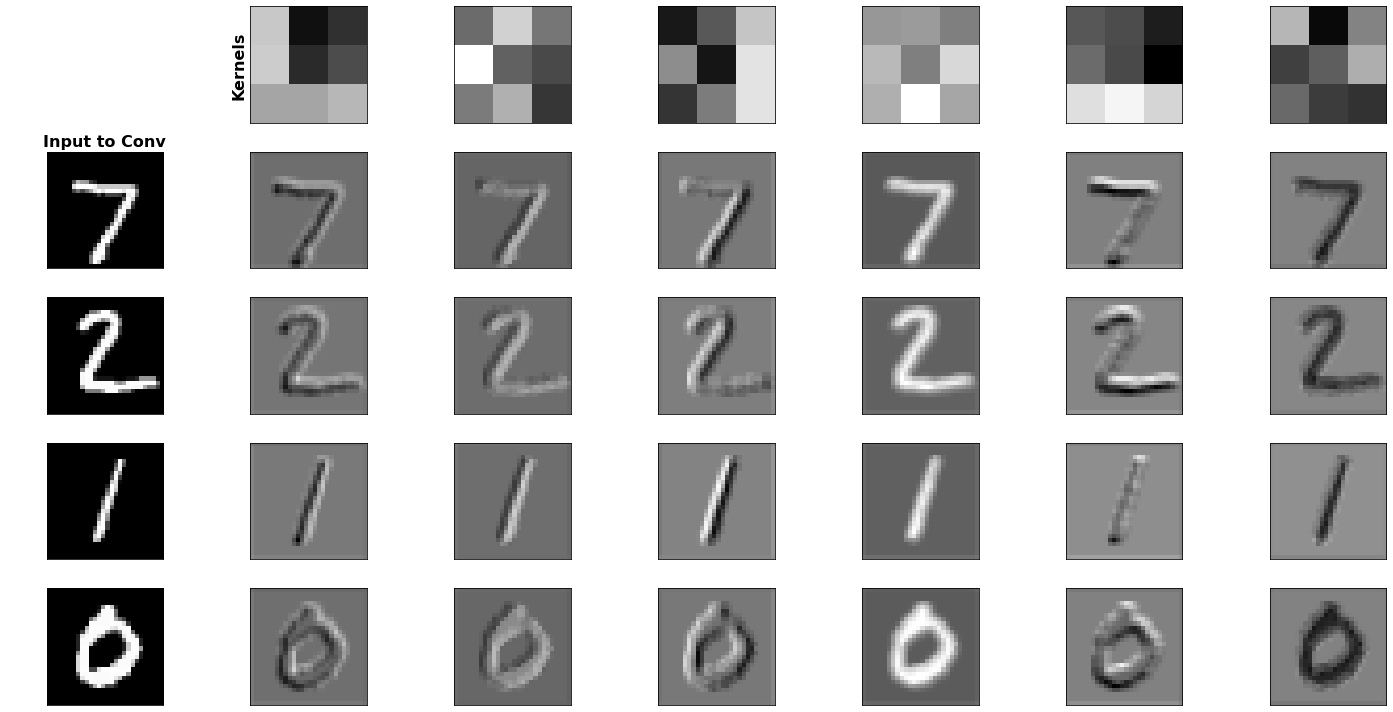

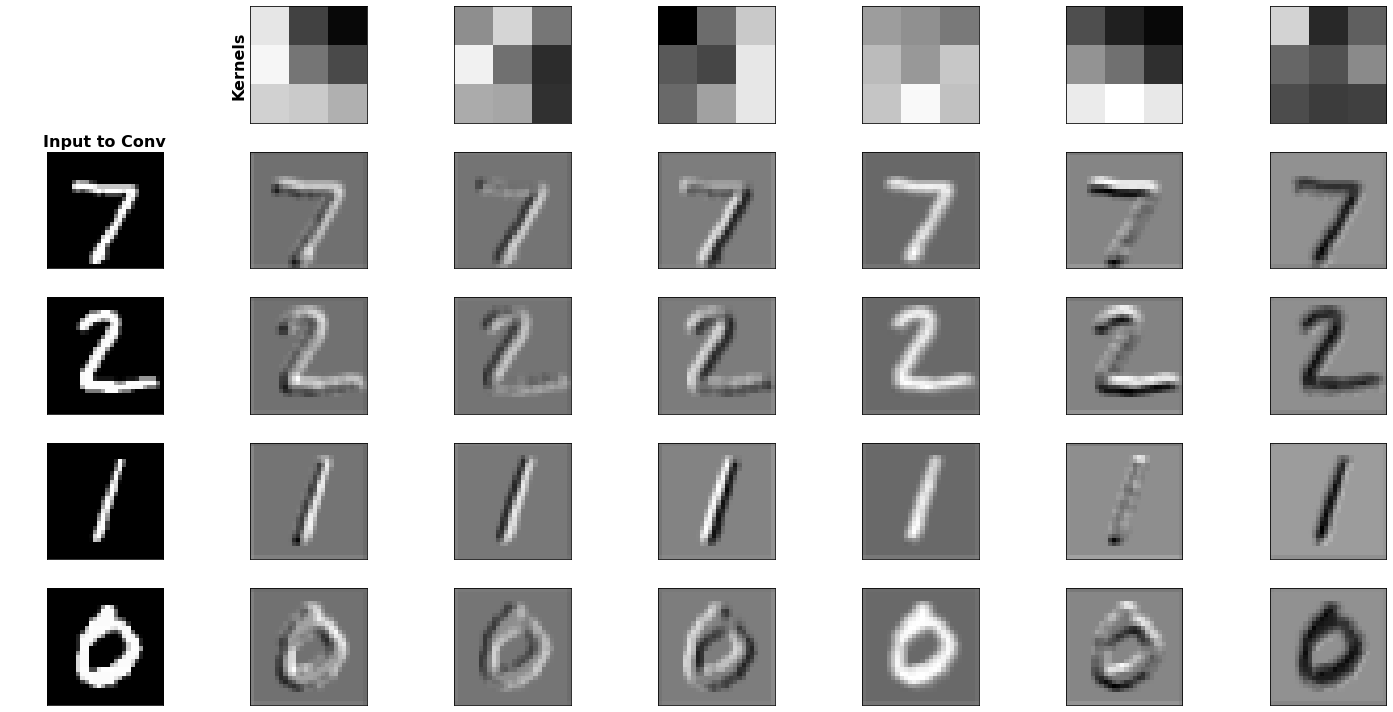

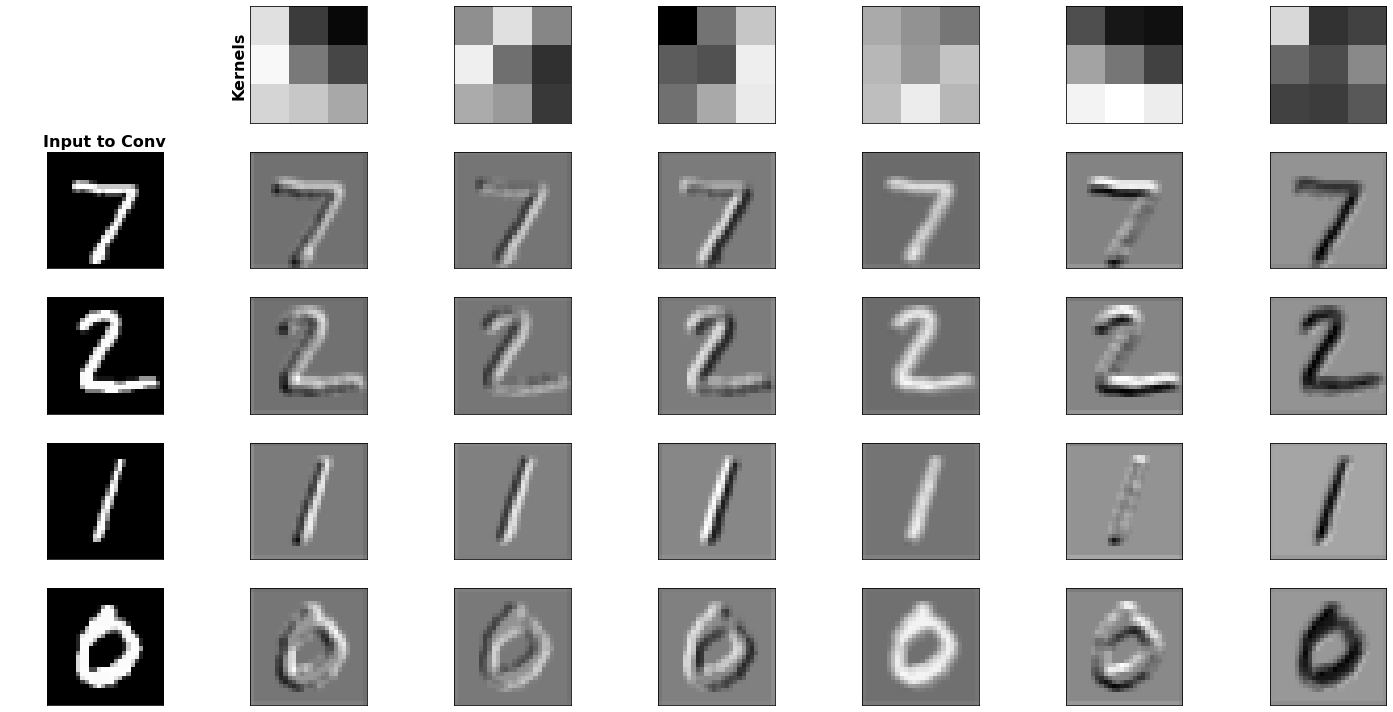

In [163]:
wandb.login()

# mnist = MNISTDataModule()
data = mnist
test_sample = next(iter(data.test_dataloader()))
input_shape = test_sample[0][0].shape
input_size = input_shape.numel()
in_channels = input_shape[0]
in_dim = input_shape[1]
n_classes = len(data.val_dataloader().dataset.dataset.classes)

# model
# classifier = MLP(input_size=input_size, n_classes=n_classes)
classifier = DeepCNN(in_channels=in_channels, in_dim=in_dim, n_classes=n_classes)


image_classifier = ImageClassifier(in_dims=input_shape, classifier=classifier)

callbacks = [
    pl.callbacks.EarlyStopping('val/loss', patience=5),
    ImagePredictionLogger(test_sample),
    FeatureActivationsLogger(test_sample)
]
wandb_logger = WandbLogger(project="lit-wandb")


trainer = pl.Trainer(
    logger=wandb_logger,
    accelerator='gpu',
    callbacks=callbacks,
    # profiler="simple",
    max_epochs=2
)

trainer.fit(image_classifier, data)

wandb.finish()